# List Mode Data Processing with GammaFlow

This notebook demonstrates processing list mode (event-by-event) gamma-ray data using the GammaFlow library.

## Overview

List mode data consists of individual detection events with:
- Time deltas (time since previous event)
- Energies (or pulse heights)

We'll cover:
1. Loading and exploring list mode data
2. Converting to spectral time series
3. Time windowing and integration
4. Analysis and visualization


## Dataset

This notebook uses the **TopCoder Urban Data Challenge** dataset, which simulates a 2"x4"x16" NaI(Tl) detector driving through an urban environment.

**Source Types (SourceID)**:
1. **HEU**: Highly enriched uranium
2. **WGPu**: Weapons-grade plutonium
3. **¹³¹I**: Iodine, a medical isotope
4. **⁶⁰Co**: Cobalt, an industrial isotope
5. **⁹⁹ᵐTc**: Technetium, a medical isotope
6. **⁹⁹ᵐTc + HEU**: A combination of Technetium and HEU

Each measurement run contains list mode data (time-stamped photon events) with the source appearing at a specific time during the measurement.

Here is the citation for the dataset:
Ghawaly, J.M., Nicholson, A.D., Peplow, D.E. et al. Data for training and testing radiation detection algorithms in an urban environment. Sci Data 7, 328 (2020). https://doi.org/10.1038/s41597-020-00672-2


## Setup


In [25]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# GammaFlow imports
from gammaflow import Spectrum, SpectralTimeSeries, ListMode
from gammaflow.visualization import plot_spectrum, plot_waterfall, plot_count_rate_time_series

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

%matplotlib inline


## 1. Load and Explore Data


In [26]:
import pandas as pd

def load_listmode_run(run_id, data_dir='../topcoder', dataset='training'):
    """
    Load a single listmode run from the TopCoder dataset.
    
    Parameters
    ----------
    run_id : int
        Run identifier (e.g., 100001)
    data_dir : str
        Path to topcoder dataset directory
    dataset : str
        'training' or 'testing'
        
    Returns
    -------
    listmode : ListMode
        ListMode object with time_deltas and energies
    metadata : dict
        Dictionary containing run metadata from answerKey
        
    Notes
    -----
    TopCoder Dataset Format:
    - Each CSV file is a simulated measurement run
    - Detector: 2"x4"x16" NaI(Tl) driving through urban environment
    - Listmode format: [time_delta_us, energy_keV]
        - time_delta_us: microseconds since previous event
        - energy_keV: photon energy in keV
    
    Metadata includes:
    - RunID: Run identifier
    - SourceID: Radioactive source present (0=background, 1=HEU, 2=Co-60, etc.)
    - SourceTime: Time when source is present
    - Part: Dataset part (1=training, 2=testing)
    - Speed/Offset: Vehicle speed or position offset
    """
    data_path = Path(data_dir)
    
    # Load listmode data
    run_file = data_path / dataset / f"{run_id}.csv"
    print(f"Loading run {run_id} from {run_file}")
    
    # Read CSV: column 0 = time_delta (microseconds), column 1 = energy (keV)
    data = pd.read_csv(run_file, header=None, names=['time_delta_us', 'energy_keV'])
    
    # Convert time deltas from microseconds to seconds
    time_deltas = data['time_delta_us'].values * 1e-6  # us -> s
    energies = data['energy_keV'].values
    
    print(f"  Loaded {len(time_deltas):,} events")
    print(f"  Duration: {time_deltas.sum():.2f} seconds")
    print(f"  Energy range: [{energies.min():.1f}, {energies.max():.1f}] keV")
    
    # Load metadata from answerKey
    answer_key_file = data_path / 'scorer' / f'answerKey_{dataset}.csv'
    answer_key = pd.read_csv(answer_key_file)
    
    # Get metadata for this run
    run_metadata = answer_key[answer_key['RunID'] == run_id]
    
    if len(run_metadata) == 0:
        print(f"  Warning: No metadata found for run {run_id}")
        metadata = {'RunID': run_id}
    else:
        metadata = run_metadata.iloc[0].to_dict()
        
        # Map SourceID to source name (correct mapping from dataset README)
        source_map = {
            0: 'Background',
            1: 'HEU',                    # Highly enriched uranium
            2: 'WGPu',                   # Weapons-grade plutonium  
            3: 'I-131',                  # Iodine (medical isotope)
            4: 'Co-60',                  # Cobalt (industrial isotope)
            5: 'Tc-99m',                 # Technetium (medical isotope)
            6: 'Tc-99m + HEU'            # Combination
        }
        metadata['SourceName'] = source_map.get(metadata['SourceID'], f"Unknown({metadata['SourceID']})")
        
        print(f"  Source: {metadata['SourceName']} (ID: {metadata['SourceID']})")
        print(f"  Source Time: {metadata['SourceTime']}")
        print(f"  Speed/Offset: {metadata['Speed/Offset']:.3f}")
    
    # Create ListMode object
    listmode = ListMode(time_deltas, energies, metadata=metadata)
    
    return listmode, metadata


# Example: Load a single run
run_id = 100001
listmode, metadata = load_listmode_run(run_id)

print(f"\n{listmode}")
print(f"Mean event rate: {listmode.mean_rate:.1f} CPS")
print(f"Total time: {listmode.total_time:.2f} s")


Loading run 100001 from ../topcoder/training/100001.csv
  Loaded 57,812 events
  Duration: 63.28 seconds
  Energy range: [11.0, 2764.1] keV
  Source: Background (ID: 0.0)
  Source Time: 0.0
  Speed/Offset: 0.336

ListMode(n_events=57812, duration=63.28s, rate=913.5Hz)
Mean event rate: 913.5 CPS
Total time: 63.28 s


### Convert ListMode to SpectralTimeSeries

We'll convert the event-by-event list mode data into a time series of spectra using rolling time windows.


In [27]:
# Convert ListMode to SpectralTimeSeries using rolling time windows
# Parameters:
#   - integration_time: Width of each time window (0.5 seconds)
#   - stride_time: Time between window starts (0.5 seconds)
#   - energy_bins: Number of energy bins for spectra

integration_time = 0.5  # seconds
stride_time = 0.5       # seconds 
energy_bins = 512       # Number of energy bins

print(f"Converting ListMode to SpectralTimeSeries...")
print(f"  Integration time: {integration_time} s")
print(f"  Stride time:      {stride_time} s")
print(f"  Energy bins:      {energy_bins}")
print(f"  Window overlap:   {(1 - stride_time/integration_time)*100:.0f}%")

# Create time series from list mode data
time_series = SpectralTimeSeries.from_list_mode(
    listmode,
    integration_time=integration_time,
    stride_time=stride_time,
    energy_bins=energy_bins,
    energy_range=(0, 3000)  # 0-3000 keV range
)

print(f"\nCreated: {time_series}")
print(f"  Number of spectra: {time_series.n_spectra}")
print(f"  Energy bins:       {time_series.n_bins}")
print(f"  Time coverage:     {time_series.timestamps[0]:.1f} to {time_series.timestamps[-1]:.1f} s")
print(f"  Energy range:      {time_series.energy_edges[0]:.1f} to {time_series.energy_edges[-1]:.1f} keV")

# Quick look at the time series structure
print(f"\nFirst spectrum:")
first_spec = time_series[0]
print(f"  Timestamp:    {first_spec.timestamp:.2f} s")
print(f"  Real time:    {first_spec.real_time:.2f} s")
print(f"  Total counts: {np.sum(first_spec.counts):.0f}")
print(f"  Count rate:   {np.sum(first_spec.count_rate):.1f} CPS")


Converting ListMode to SpectralTimeSeries...
  Integration time: 0.5 s
  Stride time:      0.5 s
  Energy bins:      512
  Window overlap:   0%

Created: SpectralTimeSeries(n_spectra=127, n_bins=512, calibrated, calibration_mode=shared)
  Number of spectra: 127
  Energy bins:       512
  Time coverage:     0.2 to 63.2 s
  Energy range:      0.0 to 3000.0 keV

First spectrum:
  Timestamp:    0.25 s
  Real time:    0.50 s
  Total counts: 438
  Count rate:   876.0 CPS


## 2. Visualize the Time Series

We'll use GammaFlow's built-in visualization tools to explore the data.


Creating total spectrum plot...


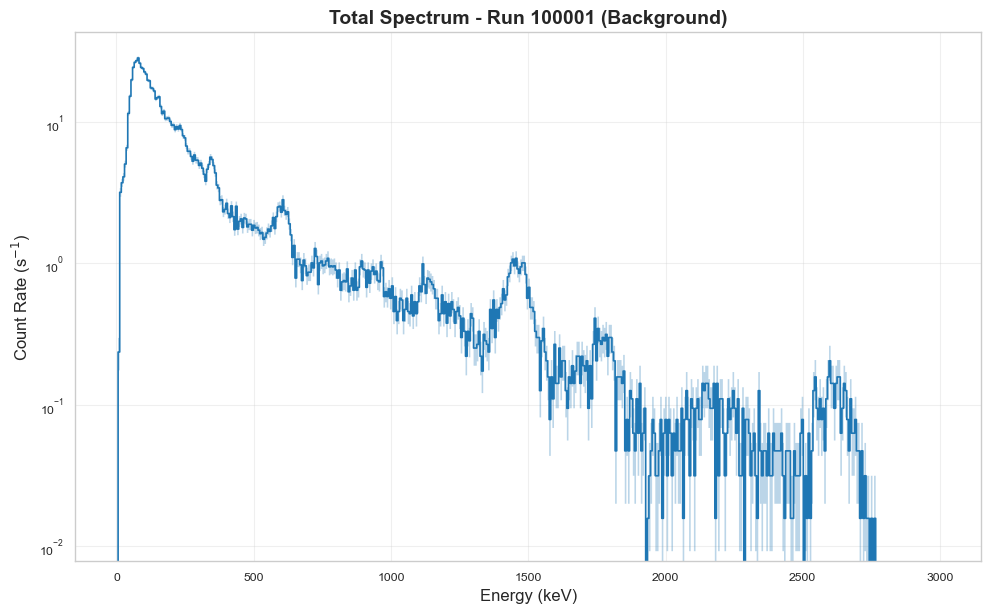


Creating count rate time series plot...


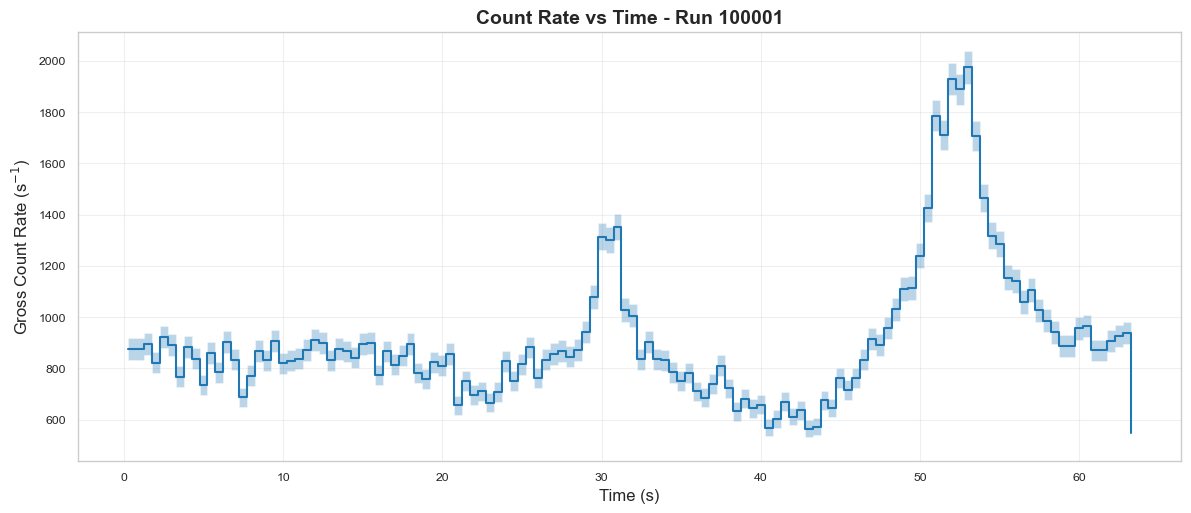


Creating waterfall plot...


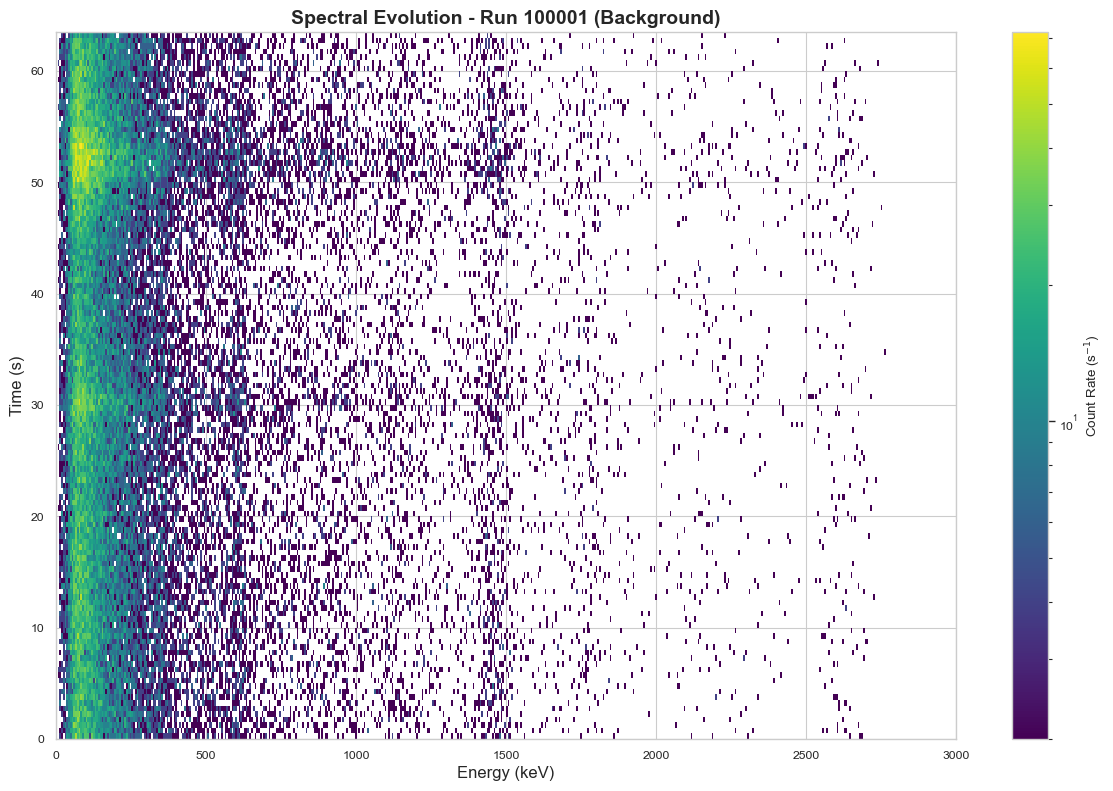


Visualization Summary:
1. Total Spectrum: Shows energy distribution summed over entire run
2. Count Rate: Shows temporal variation in detection rate
3. Waterfall: Shows how spectrum evolves over time


In [28]:
# 1. Plot the total (summed) spectrum
print("Creating total spectrum plot...")
total_spectrum = time_series.sum_spectrum()
fig1, ax1 = plot_spectrum(
    total_spectrum,
    mode='count_rate',
    log_y=True,
    show_uncertainty=True
)
ax1.set_title(f'Total Spectrum - Run {run_id} ({metadata["SourceName"]})', 
              fontsize=14, fontweight='bold')
plt.show()

# 2. Plot count rate over time
print("\nCreating count rate time series plot...")
fig2, ax2 = plot_count_rate_time_series(
    time_series,
    mode='gross',
    show_uncertainty=True
)
ax2.set_title(f'Count Rate vs Time - Run {run_id}', fontsize=14, fontweight='bold')

# Add vertical line indicating when source appears (if applicable)
if metadata['SourceID'] != 0 and metadata['SourceTime'] > 0:
    ax2.axvline(metadata['SourceTime'], color='red', linestyle='--', 
                linewidth=2, label=f"Source appears: {metadata['SourceName']}")
    ax2.legend(loc='best')

plt.show()

# 3. Plot waterfall (2D spectral evolution)
print("\nCreating waterfall plot...")
fig3, ax3 = plot_waterfall(
    time_series,
    mode='count_rate',
    log_scale=True,
    energy_range=(0, 3000),
    cmap='viridis'
)
ax3.set_title(f'Spectral Evolution - Run {run_id} ({metadata["SourceName"]})', 
              fontsize=14, fontweight='bold')

# Add horizontal line indicating when source appears (if applicable)
if metadata['SourceID'] != 0 and metadata['SourceTime'] > 0:
    ax3.axhline(metadata['SourceTime'], color='red', linestyle='--', 
                linewidth=2, alpha=0.8)
    # Add text annotation
    ax3.text(2900, metadata['SourceTime'], f"  {metadata['SourceName']}", 
             color='red', fontsize=10, va='center', fontweight='bold')

plt.show()

print("\n" + "="*60)
print("Visualization Summary:")
print("="*60)
print(f"1. Total Spectrum: Shows energy distribution summed over entire run")
print(f"2. Count Rate: Shows temporal variation in detection rate")
print(f"3. Waterfall: Shows how spectrum evolves over time")
if metadata['SourceID'] != 0:
    print(f"\nNote: Red line indicates when {metadata['SourceName']} source appears")
    print(f"      at t = {metadata['SourceTime']:.1f} seconds")


## 3. Reintegrate to Higher Integration Time and Coarser Time Resolution

We can change the integration and stide time of a SpectralTimeSeries


Reintegrating time series to 1 second windows...
Original integration time: 0.5 s
Original stride time:      0.5 s
Original number of spectra: 127

Reintegrated time series:
  New integration time: 5.0 s
  New stride time:      1.0 s
  New number of spectra: 64

Plotting count rate at new integration and stride times...


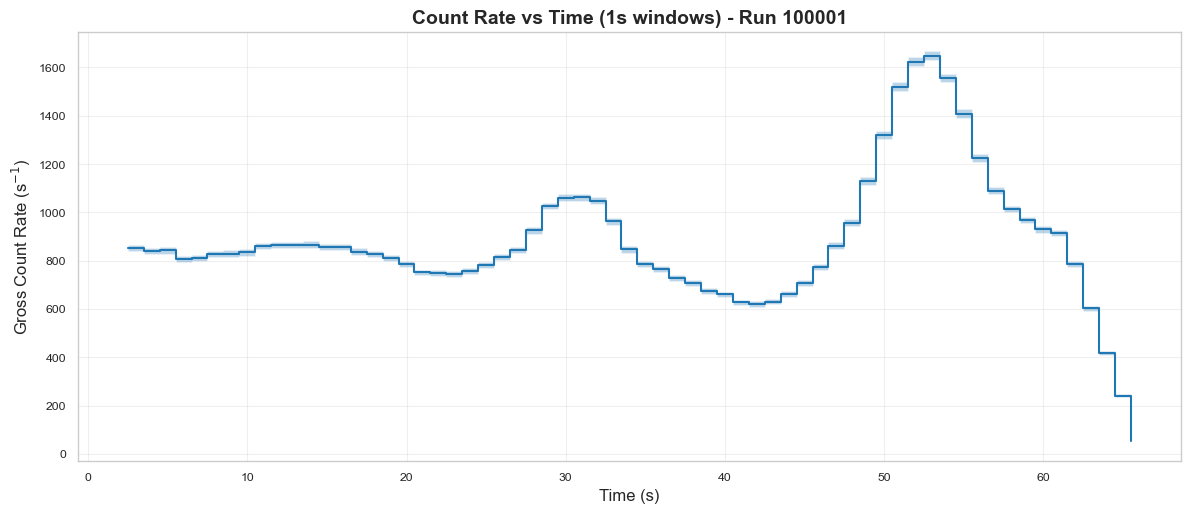


Compare the two count rate plots:
Original (0.5s windows): 127 time points
Reintegrated (5s windows): 64 time points

Observations you should make:
  • Higher integration time reduces noise.
  • Less detailed rate variations
  • Trade-off: Washes out fast transient features


In [29]:
# Reintegrate to 5 second integration time and 1 second stride time
# This provides coarser temporal resolution and less noise than the original 0.5-second windows

print("Reintegrating time series to 1 second windows...")
print(f"Original integration time: {time_series.integration_time} s")
print(f"Original stride time:      {time_series.stride_time} s")
print(f"Original number of spectra: {time_series.n_spectra}")

# Create new time series with 1-second integration
# Note: integration_time must be evenly multiple of original (5/0.5 = 10)
time_series_1s = time_series.reintegrate(
    new_integration_time=5.0,
    new_stride_time=1.0
)

print(f"\nReintegrated time series:")
print(f"  New integration time: {time_series_1s.integration_time} s")
print(f"  New stride time:      {time_series_1s.stride_time} s") 
print(f"  New number of spectra: {time_series_1s.n_spectra}")

# Plot count rate with finer resolution
print("\nPlotting count rate at new integration and stride times...")
fig3, ax3 = plot_count_rate_time_series(
    time_series_1s,
    mode='gross',
    show_uncertainty=True
)
ax3.set_title(f'Count Rate vs Time (1s windows) - Run {run_id}', 
              fontsize=14, fontweight='bold')

plt.show()

print("\n" + "="*60)
print("Compare the two count rate plots:")
print("="*60)
print(f"Original (0.5s windows): {time_series.n_spectra} time points")
print(f"Reintegrated (5s windows): {time_series_1s.n_spectra} time points")
print(f"\nObservations you should make:")
print(f"  • Higher integration time reduces noise.")
print(f"  • Less detailed rate variations")
print(f"  • Trade-off: Washes out fast transient features")


## 4. Load Run with a Source

Now let's analyze a run where a radioactive source is present. We'll use Co-60, which has characteristic gamma rays at 1173 and 1332 keV.


Loading run with radioactive source...
Loading run 107313 from ../topcoder/training/107313.csv
  Loaded 60,257 events
  Duration: 60.81 seconds
  Energy range: [11.0, 2963.1] keV
  Source: Co-60 (ID: 4.0)
  Source Time: 44.8
  Speed/Offset: 0.801

ListMode(n_events=60257, duration=60.81s, rate=990.9Hz)
Mean event rate: 990.9 CPS
Total time: 60.81 s

Converting to SpectralTimeSeries...
Created: SpectralTimeSeries(n_spectra=122, n_bins=512, calibrated, calibration_mode=shared)
  Number of spectra: 122
  Time coverage:     0.2 to 60.8 s

Visualizing Co-60 Spectrum (Time-Windowed)
Integrating spectrum around source time:
  Source time: 44.8 s
  Time window: 2.0 s
  Integration range: [43.8, 45.8] s

Spectrum statistics:
  Windowed spectrum (±1.0s): 3728 counts
  Total spectrum (all time):  60257 counts
  Ratio (windowed/total):     6.19%


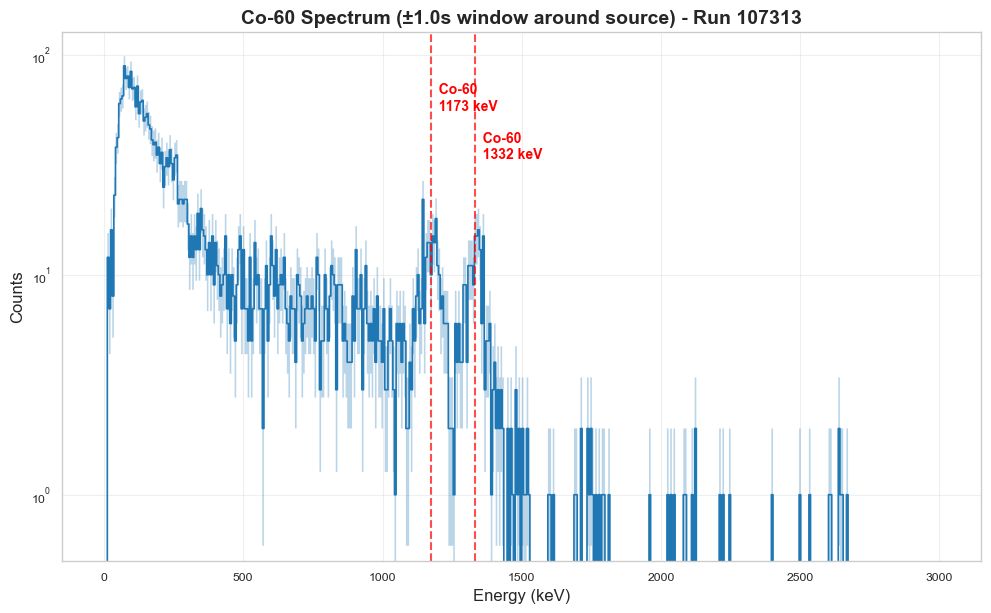


Key Insight:
  By integrating only the ±1s window around the source,
  the Co-60 photopeaks are MUCH more prominent relative
  to background compared to the full time integration!

Plotting count rate time series...


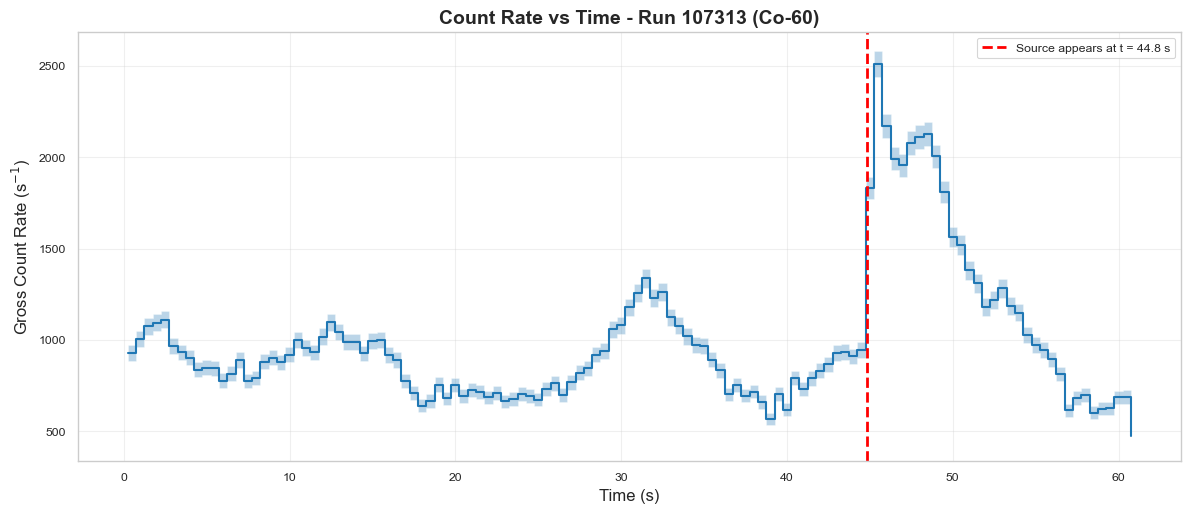


Observations:
• Co-60 photopeaks clearly visible at 1173 and 1332 keV
• Source appears at t = 44.8 seconds
• Count rate increases significantly when source is present


In [30]:
# Load a run with Co-60 source (SourceID = 4)
# Co-60 has two prominent gamma rays at 1173 keV and 1332 keV

run_id_source = 107313  # Co-60 run (SourceTime=44.8s, Speed/Offset=0.80)
print(f"Loading run with radioactive source...")
print("="*60)

listmode_source, metadata_source = load_listmode_run(run_id_source)

print(f"\n{listmode_source}")
print(f"Mean event rate: {listmode_source.mean_rate:.1f} CPS")
print(f"Total time: {listmode_source.total_time:.2f} s")

# Convert to time series with same parameters as before
integration_time = 0.5  # seconds
stride_time = 0.5       # seconds  
energy_bins = 512       # Number of energy bins

print(f"\nConverting to SpectralTimeSeries...")
time_series_source = SpectralTimeSeries.from_list_mode(
    listmode_source,
    integration_time=integration_time,
    stride_time=stride_time,
    energy_bins=energy_bins,
    energy_range=(0, 3000)  # 0-3000 keV range
)

print(f"Created: {time_series_source}")
print(f"  Number of spectra: {time_series_source.n_spectra}")
print(f"  Time coverage:     {time_series_source.timestamps[0]:.1f} to {time_series_source.timestamps[-1]:.1f} s")

# Plot the spectrum integrated around the source time
# This highlights the source peaks by excluding background before/after
print("\n" + "="*60)
print("Visualizing Co-60 Spectrum (Time-Windowed)")
print("="*60)

# Define time window around source appearance
source_time = metadata_source['SourceTime']
time_window = 2.0  # seconds (±1s around source time)

t_min = source_time - time_window / 2
t_max = source_time + time_window / 2

print(f"Integrating spectrum around source time:")
print(f"  Source time: {source_time:.1f} s")
print(f"  Time window: {time_window:.1f} s")
print(f"  Integration range: [{t_min:.1f}, {t_max:.1f}] s")

# Get windowed spectrum (only near source)
source_spectrum = time_series_source.sum_spectrum(t_min=t_min, t_max=t_max)

# Get full spectrum for comparison
total_spectrum = time_series_source.sum_spectrum()

print(f"\nSpectrum statistics:")
print(f"  Windowed spectrum (±{time_window/2:.1f}s): {source_spectrum.counts.sum():.0f} counts")
print(f"  Total spectrum (all time):  {total_spectrum.counts.sum():.0f} counts")
print(f"  Ratio (windowed/total):     {source_spectrum.counts.sum()/total_spectrum.counts.sum():.2%}")

# Plot windowed spectrum
fig, ax = plot_spectrum(
    source_spectrum,
    mode='counts',
    log_y=True,
    show_uncertainty=True
)
ax.set_title(f'Co-60 Spectrum (±{time_window/2:.1f}s window around source) - Run {run_id_source}', 
             fontsize=14, fontweight='bold')

# Annotate Co-60 photopeaks
ax.axvline(1173, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
ax.axvline(1332, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
ax.text(1173, ax.get_ylim()[1]*0.5, '  Co-60\n  1173 keV', 
        color='red', fontsize=10, va='center', fontweight='bold')
ax.text(1332, ax.get_ylim()[1]*0.3, '  Co-60\n  1332 keV', 
        color='red', fontsize=10, va='center', fontweight='bold')

plt.show()

print("\nKey Insight:")
print("  By integrating only the ±1s window around the source,")
print("  the Co-60 photopeaks are MUCH more prominent relative")
print("  to background compared to the full time integration!")

# Plot count rate over time - should show increase when source is near
print("\nPlotting count rate time series...")
fig2, ax2 = plot_count_rate_time_series(
    time_series_source,
    mode='gross',
    show_uncertainty=True
)
ax2.set_title(f'Count Rate vs Time - Run {run_id_source} ({metadata_source["SourceName"]})', 
              fontsize=14, fontweight='bold')

# Mark when source appears
if metadata_source['SourceTime'] > 0:
    ax2.axvline(metadata_source['SourceTime'], color='red', linestyle='--', 
                linewidth=2, label=f"Source appears at t = {metadata_source['SourceTime']:.1f} s")
    ax2.legend(loc='best')

plt.show()

print("\n" + "="*60)
print("Observations:")
print("="*60)
print(f"• Co-60 photopeaks clearly visible at 1173 and 1332 keV")
print(f"• Source appears at t = {metadata_source['SourceTime']:.1f} seconds")
print(f"• Count rate increases significantly when source is present")
